In [56]:
from mapbuilder import MapBuilder
from invprojection import  RBFinv, Pinv_ilamp, NNinv_torch, SSNP, PPinvWrapper
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.manifold import TSNE, MDS
from sklearn.linear_model import LogisticRegression
from umap import UMAP
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import time
import matplotlib.patheffects as PathEffects
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [57]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = np.array(X)
y = np.array(y)
X = X.astype('float32') / 255.
y = y.astype('int')
X, _, y, _ = train_test_split(X, y, train_size=5000, stratify=y, random_state=420)

# clf = RandomForestClassifier(n_estimators=100, random_state=420)
# clf = DecisionTreeClassifier(random_state=420)
# clf.fit(X, y)

/home/yuwang/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


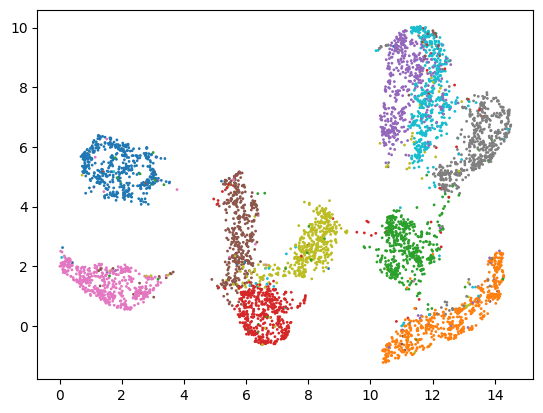

In [66]:
# PPinv = PPinvWrapper(TSNE(n_components=2, random_state=0), Pinv_ilamp())
# PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), Pinv_ilamp())
# PPinv = PPinvWrapper(TSNE(n_components=2, random_state=0), RBFinv())
PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), RBFinv())
# PPinv = PPinvWrapper(TSNE(n_components=2, random_state=0), NNinv_torch(dims=(32, 64, 128, 512)))
PPinv.fit(X=X, y=y)
X2D = PPinv.X2d

plt.scatter(X2D[:, 0], X2D[:, 1], c=y, cmap='tab10', s=1)

In [67]:
builder = MapBuilder(PPinv, None, X2d=X2D, X=X, y=y, scaling=0.9)

GRID = 256
initial_resolution = 32

n_classes: 10


Loss: 1.4765: 100%|██████████| 150/150 [00:05<00:00, 26.46it/s]


In [68]:


img, _, _ = builder.get_map(resolution=GRID)
img_fast, _, _ = builder.get_map(resolution=GRID, fast_strategy=True, initial_resolution=initial_resolution)
diff = (img != img_fast)


slow strategy
fast strategy


In [69]:
label_diff = np.array([img != img_fast]).squeeze()
x_, y_ = np.where(label_diff)

In [70]:
def plot_split(ax, sparse, grid=None, plot_center=False):
    threshold = 0
    ax.scatter(sparse[:, 0].min()+0.5, sparse[:, 1].min()+0.5, s=100, c='w')
    ax.scatter(sparse[:, 0].max()+0.5, sparse[:, 1].max()+0.5, s=100, c='w')
    for item in sparse:
        if item[-2] > threshold and item[-1] > threshold:
            w, h = item[-2], item[-1]
            # print(f'({item[0]-w/2}, {item[1]-h/2}), {w}, {h}')
            ax.add_patch(Rectangle((item[0]-w/2+.5, item[1]-h/2+.5), w, h, fill=None, edgecolor='r', lw=0.1))
            if plot_center:
                ax.scatter(item[0]+.5, item[1]+.5, c='g', s=1, marker='s')
                # print(f'({item[0]}, {item[1]}), {w}, {h}')
            # ax[2].scatter(item[0], item[1], c=item[3], s=1, marker='.', k='w')
            # ax.set_xlim(0, GRID)
            # ax.set_ylim(0, GRID)
        # else:
        #     ax[2].scatter(item[0], item[1], c=item[3], s=1, marker='s')
    if grid is not None:
        ax.set(xlim=(-2, grid), ylim=(-2, grid))
    # ax[2].set(xlim=(0-5, GRID+1), ylim=(0-5, GRID+1))

    return ax

slow strategy
4.819123983383179
fast strategy
(20711, 6)
(13791, 2)
(1738, 2)
Correct pixels: 120, wrong pixels: 1239
actual wrong pixels: 379
1.6515395641326904
slow strategy
22.078259468078613
fast strategy
relace the label with the dist_map


/home/yuwang/workspace/map_builder/mapbuilder/deepfool_neigbor.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_classes = T.tensor(labels, device=input_batch.device, dtype=T.long)


7.739265203475952


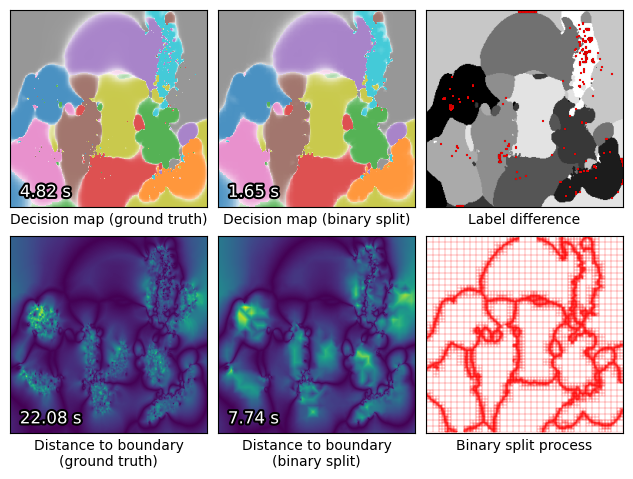

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5.5))
fig.subplots_adjust(hspace=0.15, wspace=0.02)

text_x = 0.05
text_y = 0.05
ax_list  = axes.flatten()
time0 = time.time()
_ , _ = builder.plot_decision_map(ax=ax_list[0], grid=GRID)
time1 = time.time()
time_label_gt = time1 - time0
print(time_label_gt)
ax_list[0].set_xlabel('Decision map (ground truth)')
txt0 = ax_list[0].text(text_x, text_y, f'{time_label_gt:.2f} s', fontsize=12, color='w')
txt0.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])


time0 = time.time()
_, sparse = builder.plot_decision_map(ax=ax_list[1], grid=GRID, fast=True, initial_resolution=initial_resolution)
time1 = time.time()
time_label_fast = time1 - time0
ax_list[1].set_xlabel('Decision map (binary split)')
txt1 = ax_list[1].text(text_x, text_y, f'{time_label_fast:.2f} s', fontsize=12, color='w')
txt1.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

single_pixel = sparse[sparse[:, -2] == 1][:, :2]
single_pixel_all = sparse[sparse[:, -2] == 1]

print(sparse.shape)
print(single_pixel.shape)
wrong_pixels = np.array([y_, GRID-x_]).T
filtered_pixels = []
cnt_correct = 0
cnt_wrong = 0
for i in range(wrong_pixels.shape[0]):
    condition = np.all(single_pixel == wrong_pixels[i], axis=1)
    if np.any(condition):
        # print(condition)
        # Get the index of the matching row in single_pixel
        index_in_single_pixel = np.where(condition)[0][0] # T
        # print('sparse shape', index_in_single_pixel)
        if img_fast[wrong_pixels[i][0], wrong_pixels[i][1]] == single_pixel_all[index_in_single_pixel][-3]:
            # print('this is a correct pixel')
            cnt_correct += 1
        else:
            # filtered_pixels.append(wrong_pixels[i])
            cnt_wrong += 1
        pass
    else:
        # print('this is a correct pixel')
        filtered_pixels.append(wrong_pixels[i])
filtered_pixels = np.array(filtered_pixels)
print(wrong_pixels.shape)
# for i in range(wrong_pixels.shape[1]):
#     wrong_pixel = wrong_pixels[:, i]
#     ax_list[2].scatter(wrong_pixel[0]+0.5, wrong_pixel[1]+0.5, c='r', s=1, marker='s')

ax_list[2].imshow(img/9, cmap='gray', extent=[0, GRID, 0, GRID], rasterized=True)
# ax_list[2].scatter(y_+0.5, GRID-x_-0.5, s=1, c='b', ec='k', lw=0.1, marker='s', alpha=0.95, rasterized=True)   
ax_list[2].scatter(filtered_pixels[:, 0]+0.5, filtered_pixels[:, 1]-0.5, s=1.5, c='r', ec='k', lw=0.05, marker='s', alpha=0.95, rasterized=False) 
ax_list[2].set_xlabel('Label difference')

print(f'Correct pixels: {cnt_correct}, wrong pixels: {cnt_wrong}')
print('actual wrong pixels:', len(filtered_pixels))

print(time_label_fast)

time0 = time.time()
_, _ = builder.plot_dist_map(ax=ax_list[3], grid=GRID)
time1 = time.time()
time_dist_gt = time1 - time0
print(time_dist_gt)
ax_list[3].set_xlabel('Distance to boundary\n(ground truth)')
txt3 = ax_list[3].text(text_x, text_y, f'{time_dist_gt:.2f} s', fontsize=12, color='w')
txt3.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
# ax_list[3].set_xlabel('Ground truth', fontsize=16, weight='bold', labelpad=10)

time0 = time.time()
_, _ = builder.plot_dist_map(ax=ax_list[4], grid=GRID, fast=True, initial_resolution=initial_resolution)
time1 = time.time()
time_dist_fast = time1 - time0
print(time_dist_fast)
ax_list[4].set_xlabel('Distance to boundary\n(binary split)')
# ax_list[4].set_xlabel('Binary Split', fontsize=16, weight='bold', labelpad=10)

txt4 = ax_list[4].text(text_x, text_y, f'{time_dist_fast:.2f} s', fontsize=12, color='w')
txt4.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

# plot_split(ax_list[2], sparse, GRID, plot_center=False)
# ax_list[5].set_xlabel('Binary split process')

plot_split(ax_list[5], sparse, GRID, plot_center=False)
ax_list[5].set_xlabel('Binary split process')
ax_list[5].set_xlim(-1, GRID)
ax_list[5].set_ylim(-1, GRID)

for ax in ax_list:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')






In [72]:
fig.savefig('./figures/umao_rbf_mnist.eps', dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [73]:
sparse[:, 1]

array([ -1., 256.,  -1., ...,  65., 113., 114.])